# Example Notebook for Network Visualization

### Change working directory to this root

In [1]:
import os
os.chdir("..")

### Imports

In [2]:
import random
from typing import Any

import torch
from torch.utils.data import DataLoader, _utils
import matplotlib.pyplot as plt
import torchaudio
import IPython

from utils.config import load_cfg_from_hydra
from utils.containers import MelSpecParameters
from models.mel_spec_converters import SimpleMelSpecConverter

/home/vovatch/anaconda3/envs/infected_pbm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load model

In [3]:
# weights path
import hydra

from models.modules.base import load_inner_model_state_dict

weights_path = "weights/lvl1_vqgan.ckpt"

# Infer device
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Current device is {device}")

# Load network
cfg = load_cfg_from_hydra(config_path="../config", config_name="lvl1_vqgan", overrides=["data=lvl1_vqvae"])
cfg.learning.batch_size = 128
cfg.learning.val_split = 1.0 # Will it let me do that?
model = hydra.utils.instantiate(cfg.module, _convert_="partial").to(device)
model = load_inner_model_state_dict(model, weights_path)

Current device is cpu


/home/vovatch/anaconda3/envs/infected_pbm/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


### Load data loader

In [4]:
dataset = hydra.utils.instantiate(cfg.data.dataset, _recursive_=False)
dataset_len = len(dataset)
slice_len = 32

# Select a random sample
sample_start = random.randint(0, dataset_len - slice_len - 1)
dataset_slice: dict[str, torch.Tensor] = _utils.collate.default_collate([dataset[i] for i in range(sample_start, sample_start + slice_len)]) # type: ignore
concatenated_slice = dataset_slice["slice"]

print(f"The concatenated slice dimensions are {concatenated_slice.shape}")

2025-03-05 18:28:03 - INFO - Loading processed data from data/slices...
Loading slices...: 100%|██████████| 2/2 [00:00<00:00, 26.36it/s]
2025-03-05 18:28:03 - INFO - Parsed metadata and the slices to the buffer
2025-03-05 18:28:03 - INFO - Loaded processed data


The concatenated slice dimensions are torch.Size([32, 1, 32768])


### WAV Player element

In [5]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
                of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
        <source src="files/%s" type="audio/mp3" />
        Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

### Initialize Mel-Spectrogram Converter

In [6]:
n_mels = 32
mel_spec_params = MelSpecParameters(n_fft=256, f_min=0, hop_length=64, n_mels=n_mels, power=1.0, pad=0)
mel_spec_converter = SimpleMelSpecConverter(mel_spec_params)

lin_vector = torch.linspace(
    1.0,
    1.0,
    n_mels,
)
eye_mat = torch.diag(lin_vector).to(device)

### Load data point and visualize it

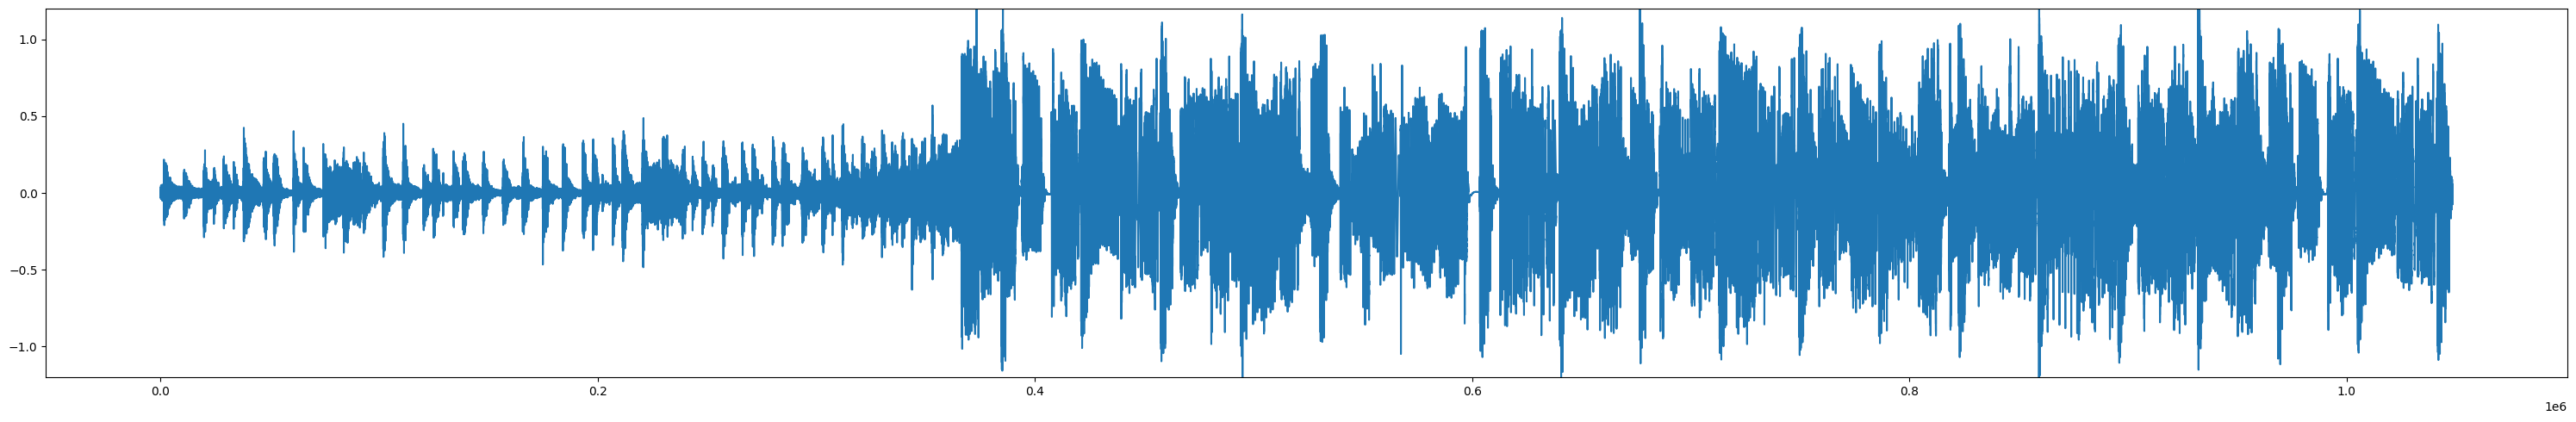

<Figure size 3000x500 with 0 Axes>

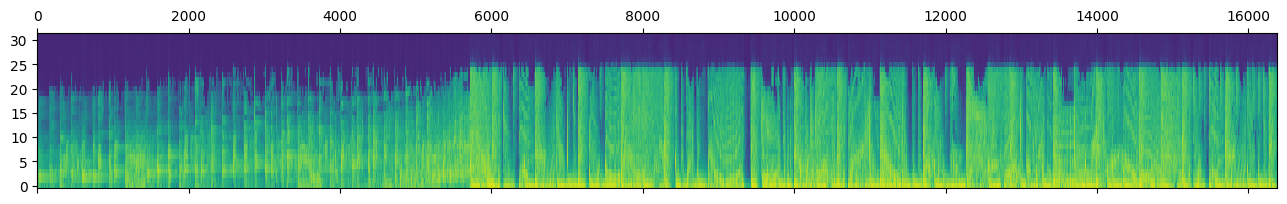

In [7]:
image_reshaped = concatenated_slice.flatten().cpu().numpy() # type: ignore
from utils.transform_func import log_normal

plt.figure(figsize=(30, 5))
plt.plot(image_reshaped)

plt.tight_layout()
plt.ylim(-1.2, 1.2)
plt.show()

plt.figure(figsize=(30, 5))
# plt.matshow(torch.tanh(eye_mat @ mel_spec_converter.convert(torch.tensor(image_reshaped))).cpu().numpy(), 
#             origin='lower', aspect='auto', vmin=0, vmax=1)
plt.matshow(log_normal(mel_spec_converter.convert(torch.tensor(image_reshaped))).cpu().numpy(), 
            origin='lower', aspect='auto', vmin=-2, vmax=2)
plt.show()

torchaudio.save('sample.mp3', concatenated_slice.flatten().unsqueeze(0).cpu().detach(), 44100, format='mp3') # type: ignore
IPython.display.Audio(filename="sample.mp3") # type: ignore

## Inference

### Perform inference

torch.Size([32, 1, 32768])
tensor(0.0082)


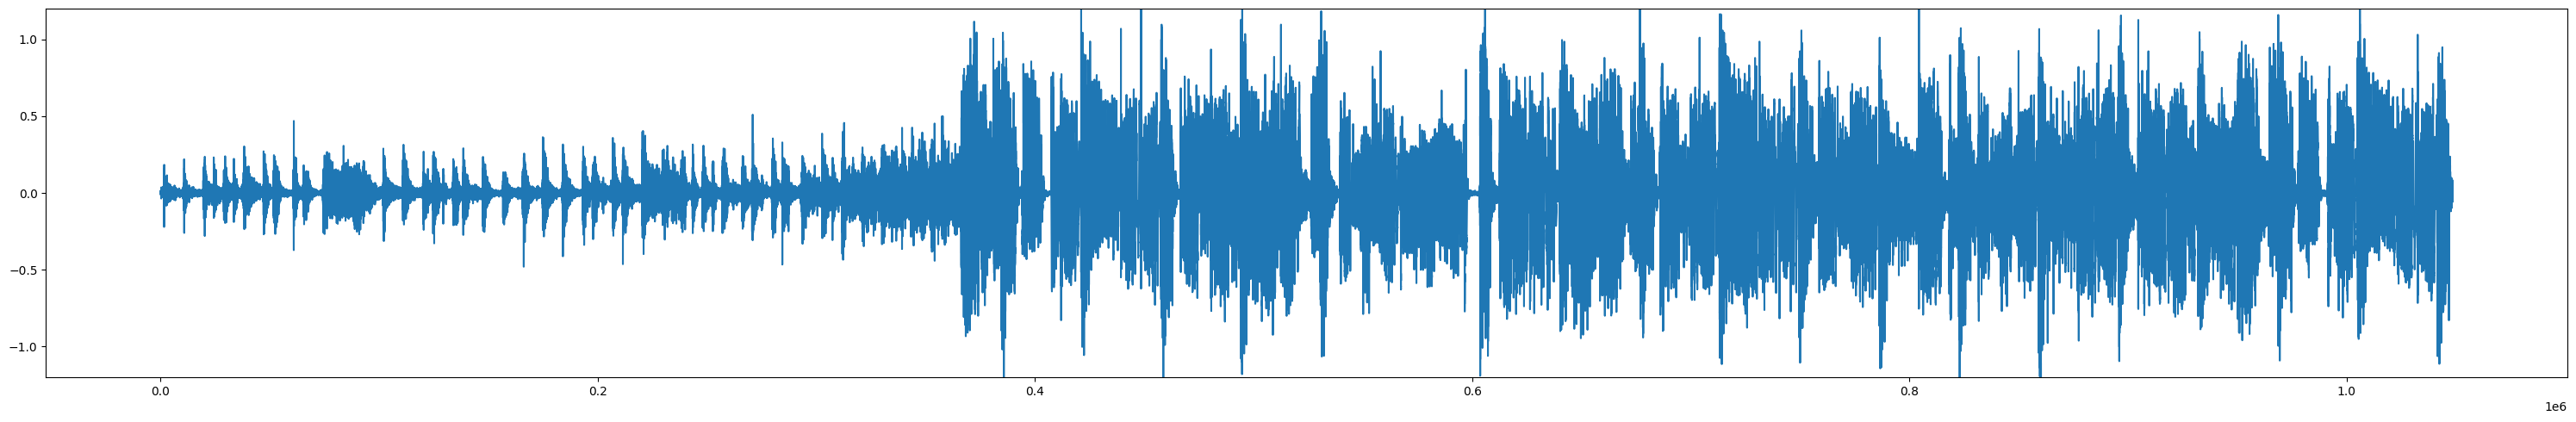

/tmp/ipykernel_839928/2205655720.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.matshow(log_normal(mel_spec_converter.convert(torch.tensor(reconstructed_slice["slice"].flatten()))).cpu().numpy(),


<Figure size 3000x500 with 0 Axes>

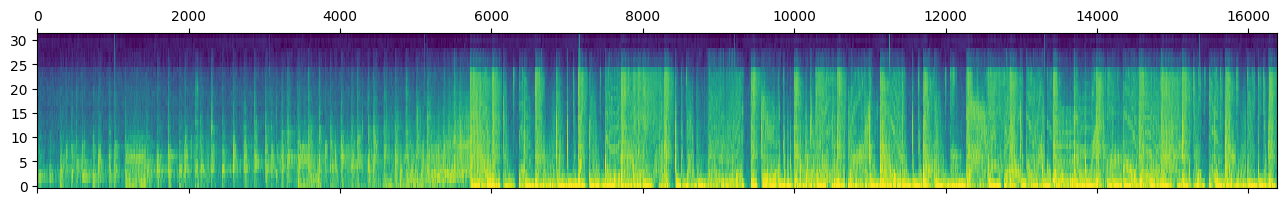

In [8]:
collated_batch = {"slice": concatenated_slice.to(device)}
print(collated_batch["slice"].shape)
with torch.no_grad():
    reconstructed_slice = model(collated_batch)
reconstructed_slice_flattened = reconstructed_slice["slice"].flatten().cpu().detach()
print(torch.nn.functional.smooth_l1_loss(reconstructed_slice["slice"], collated_batch["slice"]))

plt.figure(figsize=(30, 5))
plt.plot(reconstructed_slice_flattened)

plt.tight_layout()
plt.ylim(-1.2, 1.2)
plt.show()

plt.figure(figsize=(30, 5))
# plt.matshow(torch.tanh(eye_mat @ mel_spec_converter.convert(torch.tensor(reconstructed_slice["slice"].flatten()))).cpu().numpy(), 
#             origin='lower', aspect='auto', vmin=0, vmax=1)
plt.matshow(log_normal(mel_spec_converter.convert(torch.tensor(reconstructed_slice["slice"].flatten()))).cpu().numpy(), 
            origin='lower', aspect='auto', vmin=-2, vmax=2)
plt.show()

torchaudio.save('sample.mp3', reconstructed_slice["slice"].flatten().clip(-1, 1).unsqueeze(0).cpu().detach(), 44100, format='mp3') # type: ignore
IPython.display.Audio(filename="sample.mp3") # type: ignore

### Compare mel specs of a single 1024 length slice

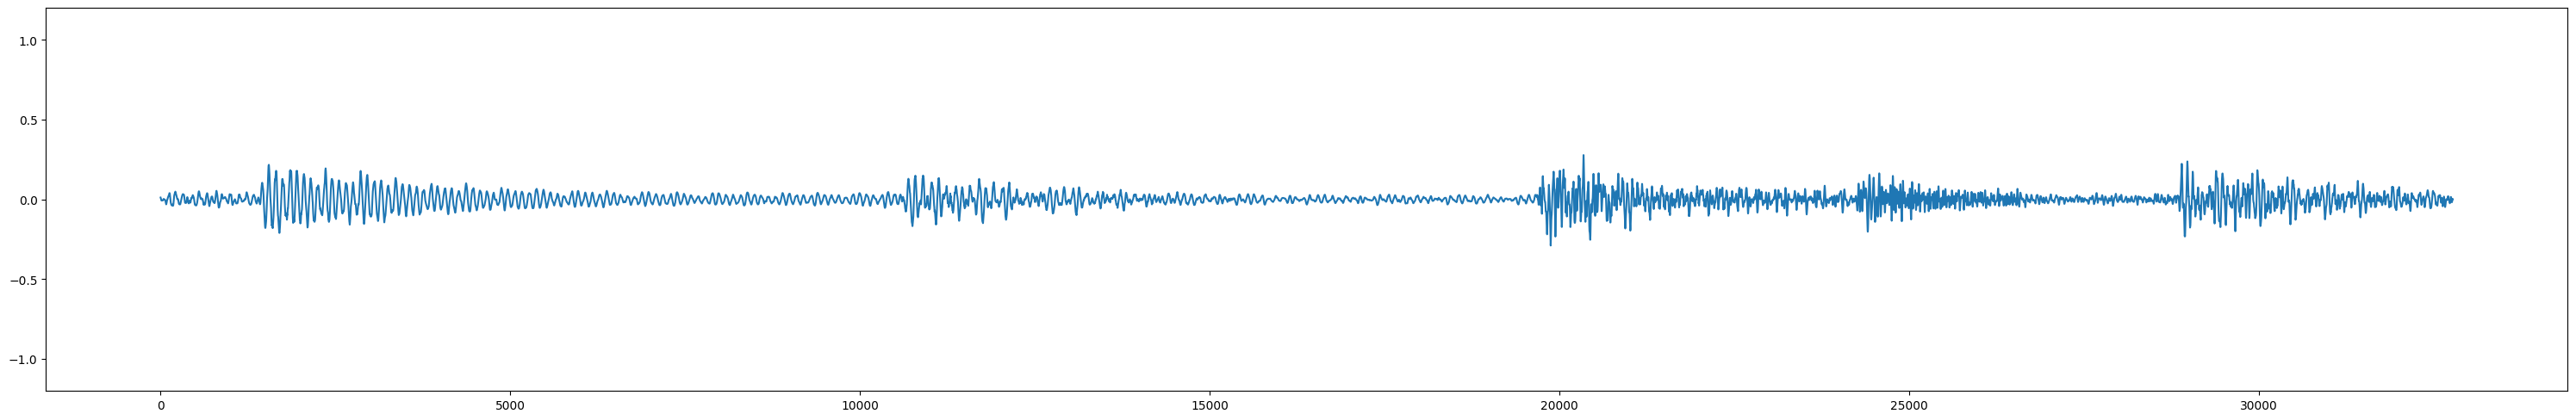

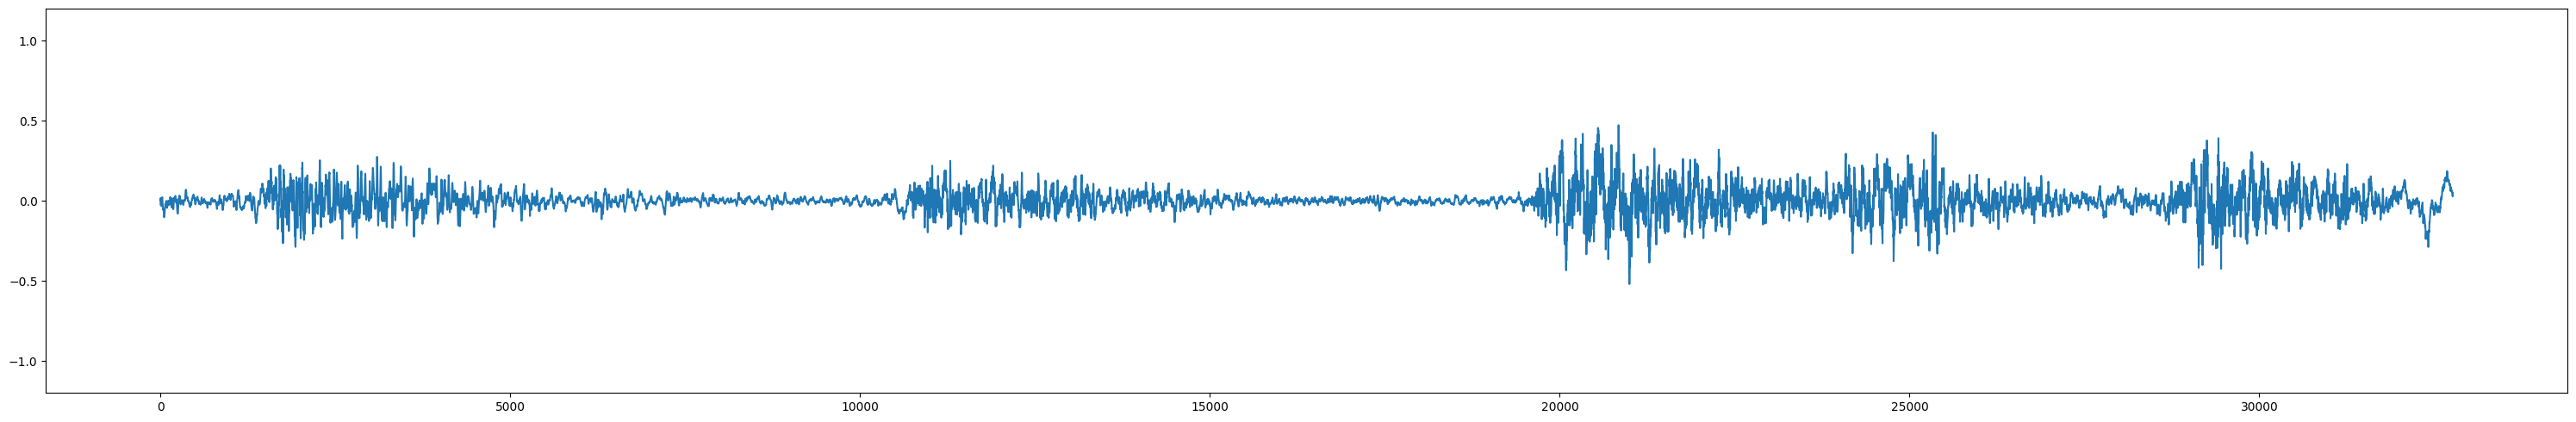

<Figure size 3000x500 with 0 Axes>

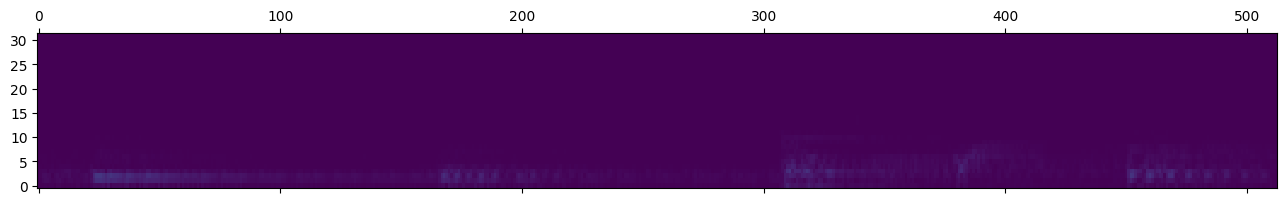

/tmp/ipykernel_839928/771494345.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eye_mat @ mel_spec_converter.convert(torch.tensor(reconstructed_single_sample["slice"].flatten()))


<Figure size 3000x500 with 0 Axes>

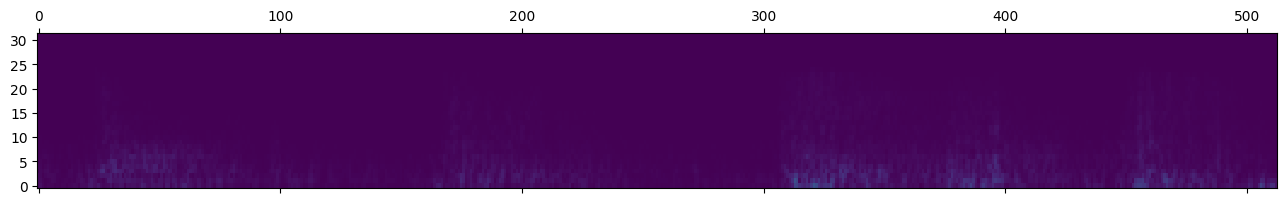

In [9]:
single_sample = dataset[sample_start]
collated_sample = {key: torch.stack((value,), dim=0).to(device) for (key, value) in single_sample.items() if key == "slice"}

with torch.no_grad():
    reconstructed_single_sample = model(collated_sample)
    
plt.figure(figsize=(30, 5))
plt.plot(collated_sample["slice"].flatten().cpu().detach().numpy())

plt.tight_layout()
plt.ylim(-1.2, 1.2)
plt.show()

plt.figure(figsize=(30, 5))
plt.plot(reconstructed_single_sample["slice"].flatten().cpu().detach().numpy())

plt.tight_layout()
plt.ylim(-1.2, 1.2)
plt.show()
    
plt.figure(figsize=(30, 5))
plt.matshow(
    torch.tanh(
        eye_mat @ mel_spec_converter.convert(collated_sample["slice"].flatten())
    ).cpu().numpy(), origin='lower', aspect='auto', vmin=0, vmax=1
)
plt.show()

plt.figure(figsize=(30, 5))
plt.matshow(
    torch.tanh(
        eye_mat @ mel_spec_converter.convert(torch.tensor(reconstructed_single_sample["slice"].flatten()))
    ).cpu().numpy(), origin='lower', aspect='auto', vmin=0, vmax=1
)
plt.show()

### Try High-Pass Filter

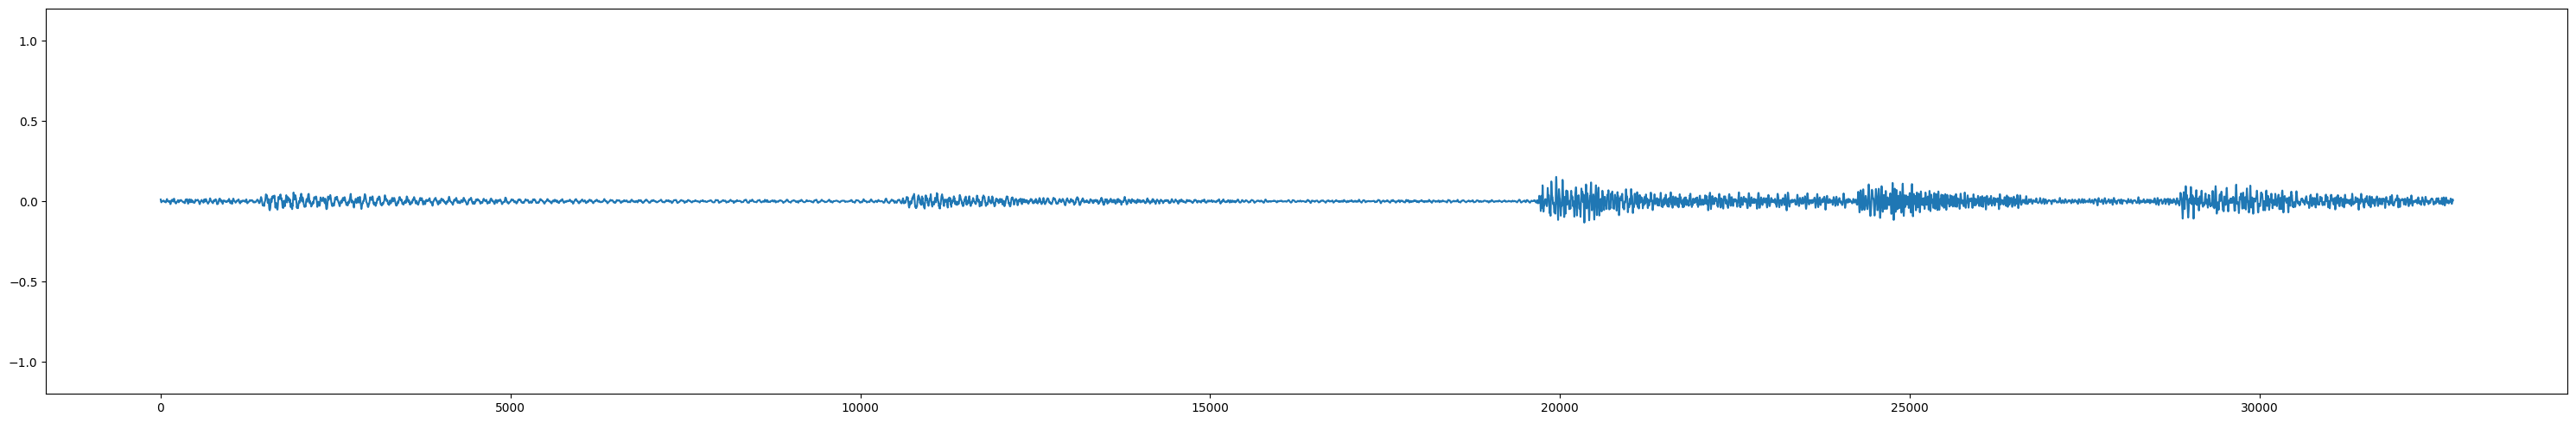

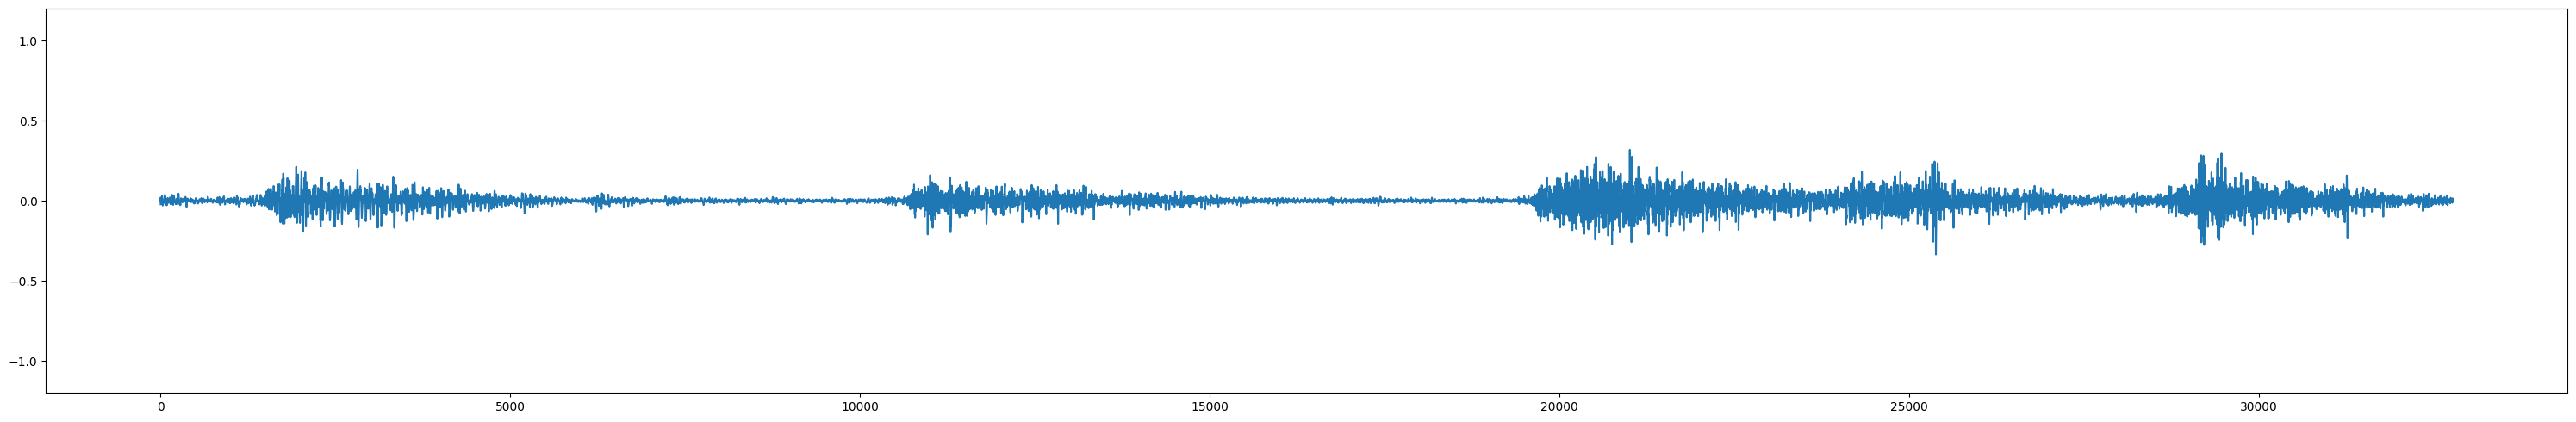

In [10]:
import torchaudio.functional as AF

high_pass_response = AF.highpass_biquad(collated_sample["slice"], 44100, 1000)
reconstructed_high_pass_response = AF.highpass_biquad(reconstructed_single_sample["slice"], 44100, 1000)

plt.figure(figsize=(30, 5))
plt.plot(high_pass_response.flatten().cpu().detach().numpy())

plt.tight_layout()
plt.ylim(-1.2, 1.2)
plt.show()

plt.figure(figsize=(30, 5))
plt.plot(reconstructed_high_pass_response.flatten().cpu().detach().numpy())

plt.tight_layout()
plt.ylim(-1.2, 1.2)
plt.show()
